Step 0/1000
Step 100/1000
Step 200/1000
Step 300/1000
Step 400/1000
Step 500/1000
Step 600/1000
Step 700/1000
Step 800/1000
Step 900/1000


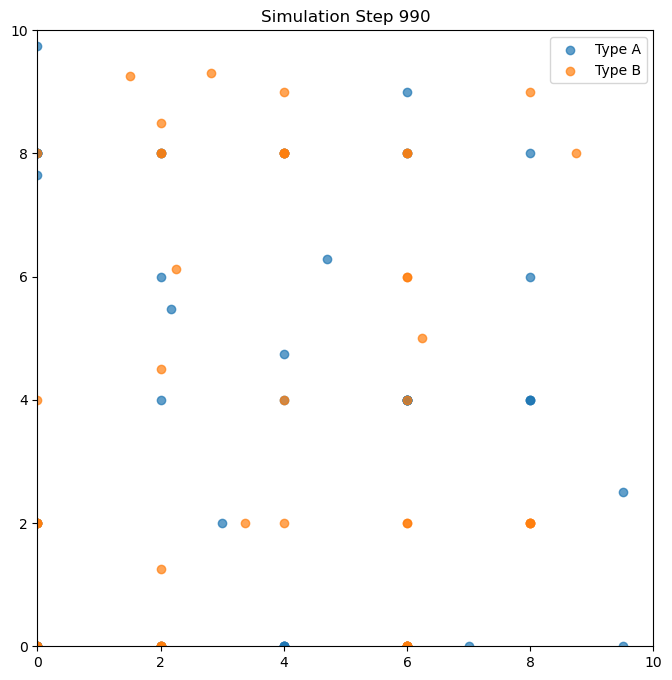

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

# ============================
# Simulation Parameters
# ============================
NUM_PARTICLES_A = 50  # Number of particles of type A
NUM_PARTICLES_B = 50  # Number of particles of type B
NUM_PARTICLES = NUM_PARTICLES_A + NUM_PARTICLES_B
BOX_SIZE = 10.0       # Size of the square simulation box
TEMPERATURE = 1.0     # Temperature for Maxwell-Boltzmann distribution
MASS_A = 1.0          # Mass of particles of type A
MASS_B = 1.0          # Mass of particles of type B
EPSILON_AA = 1.0      # Depth of Lennard-Jones potential for A-A interaction
SIGMA_AA = 1.0        # Zero-crossing distance for A-A interaction
EPSILON_BB = 1.0      # Depth of Lennard-Jones potential for B-B interaction
SIGMA_BB = 1.0        # Zero-crossing distance for B-B interaction
EPSILON_AB = 0.5      # Depth of Lennard-Jones potential for A-B interaction
SIGMA_AB = 0.8        # Zero-crossing distance for A-B interaction
TIME_STEP = 0.005     # Time step for integration
NUM_STEPS = 1000      # Number of simulation steps
OUTPUT_INTERVAL = 10  # Interval (in steps) to capture frames for the GIF


# ============================
# Utility Functions
# ============================

def initialize_positions(num_particles, box_size):
    """Initialize particle positions randomly within the simulation box."""
    return np.random.uniform(0, box_size, (num_particles, 2))  # Only x and y coordinates


def initialize_velocities(num_particles_A, num_particles_B, mass_A, mass_B, temperature):
    """Initialize particle velocities using the Maxwell-Boltzmann distribution."""
    def maxwell_boltzmann_velocity(mass, temperature, size):
        stddev = np.sqrt(temperature / mass)
        return np.random.normal(0, stddev, size)

    velocities = np.zeros((num_particles_A + num_particles_B, 2))  # Only x and y components
    velocities[:num_particles_A] = maxwell_boltzmann_velocity(mass_A, temperature, (num_particles_A, 2))
    velocities[num_particles_A:] = maxwell_boltzmann_velocity(mass_B, temperature, (num_particles_B, 2))

    # Remove center-of-mass motion to ensure momentum conservation
    velocities -= np.mean(velocities, axis=0)
    return velocities


def apply_periodic_boundary(position, box_size):
    """Apply periodic boundary conditions to keep positions within the box."""
    return position % box_size


def minimum_image(rij, box_size):
    """Apply the minimum image convention to calculate the shortest distance."""
    return rij - box_size * np.round(rij / box_size)


def lennard_jones_force(rij, epsilon, sigma):
    """Compute the Lennard-Jones force between two particles."""
    r2 = np.dot(rij, rij)
    if r2 == 0:
        return np.zeros(2)  # Avoid division by zero in case of overlap
    r6 = (sigma ** 2 / r2) ** 3
    r12 = r6 ** 2
    magnitude = 24 * epsilon * (2 * r12 - r6) / r2
    return magnitude * rij / np.sqrt(r2)


def compute_forces(positions, particle_types, num_particles,
                   epsilon_params, sigma_params, box_size):
    """Compute forces on all particles using pairwise Lennard-Jones interactions."""
    forces = np.zeros_like(positions)

    for i in range(num_particles):
        for j in range(i + 1, num_particles):
            rij = minimum_image(positions[j] - positions[i], box_size)
            type_i, type_j = particle_types[i], particle_types[j]
            epsilon = epsilon_params[type_i][type_j]
            sigma = sigma_params[type_i][type_j]
            force_ij = lennard_jones_force(rij, epsilon, sigma)

            forces[i] += force_ij
            forces[j] -= force_ij

    return forces


# ============================
# Main Simulation Function
# ============================

def simulate_binary_fluid():
    """Simulate a binary fluid interacting via Lennard-Jones potentials in a 2D box."""
    
    # Initialize positions and velocities
    positions = initialize_positions(NUM_PARTICLES, BOX_SIZE)
    velocities = initialize_velocities(NUM_PARTICLES_A, NUM_PARTICLES_B,
                                       MASS_A, MASS_B, TEMPERATURE)
    
    # Define particle types (0: A, 1: B)
    particle_types = np.array([0] * NUM_PARTICLES_A + [1] * NUM_PARTICLES_B)

    # Interaction parameters (epsilon and sigma matrices)
    epsilon_params = [[EPSILON_AA, EPSILON_AB], [EPSILON_AB, EPSILON_BB]]
    sigma_params = [[SIGMA_AA, SIGMA_AB], [SIGMA_AB, SIGMA_BB]]

    # Store positions at intervals for visualization
    trajectory_frames = []

    # Run simulation loop
    for step in range(NUM_STEPS):
        forces = compute_forces(positions,
                                particle_types,
                                NUM_PARTICLES,
                                epsilon_params,
                                sigma_params,
                                BOX_SIZE)

        # Velocity Verlet integration: update velocities and positions
        velocities += forces * TIME_STEP / MASS_A   # Assume equal mass for simplicity here
        positions += velocities * TIME_STEP

        # Apply periodic boundary conditions to positions
        positions = apply_periodic_boundary(positions, BOX_SIZE)

        if step % OUTPUT_INTERVAL == 0:
            trajectory_frames.append(positions.copy())

        if step % 100 == 0:
            print(f"Step {step}/{NUM_STEPS}")

    return trajectory_frames


# ============================
# Visualization Function (GIF)
# ============================

def create_simulation_gif(frames):
    """Create and save a GIF from the simulation frames."""
    
    fig, ax = plt.subplots(figsize=(8, 8))

    def update(frame_idx):
        ax.clear()
        
        frame_positions = frames[frame_idx]
        
        ax.scatter(frame_positions[:NUM_PARTICLES_A][:, 0],
                   frame_positions[:NUM_PARTICLES_A][:, 1],
                   label="Type A", alpha=0.7)
        
        ax.scatter(frame_positions[NUM_PARTICLES_A:][:, 0],
                   frame_positions[NUM_PARTICLES_A:][:, 1],
                   label="Type B", alpha=0.7)
        
        ax.set_xlim(0, BOX_SIZE)
        ax.set_ylim(0, BOX_SIZE)
        
        ax.set_aspect('equal', adjustable='box')
        
        ax.legend()
        
        ax.set_title(f"Simulation Step {frame_idx * OUTPUT_INTERVAL}")
    
    anim = FuncAnimation(fig,
                         update,
                         frames=len(frames),
                         interval=50)  # Interval between frames in milliseconds

    anim.save("binary_fluid_simulation_2D.gif", writer=PillowWriter(fps=20))
    

# ============================
# Run Simulation and Generate GIF
# ============================

if __name__ == "__main__":
    trajectory_frames = simulate_binary_fluid()
    create_simulation_gif(trajectory_frames)
    
